In [57]:
# !pip install rdkit-pypi
# !pip install avogadro
# !pip install py3Dmol

# Introduction to Chem-Informatics
(Reference: [**Book**](https://link.springer.com/book/10.1007/978-1-4020-6291-9))
 <a target="_blank" href="https://colab.research.google.com/github/ChemAI-Lab/Math4Chem/blob/main/website/Lecture_Notes/Coding/Intro_RdKit.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


Goals: 
1. **How do we store information about a chemical structure in a computer?**
2. Introduction to [RDKit](https://www.rdkit.org/docs/index.html).

In [78]:
import numpy as np
import matplotlib.pyplot as plt

import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdMolDescriptors, QED
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import display

import networkx as nx

IPythonConsole.ipython_useSVG = True
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,300

# Molecular descriptors

*Molecular descriptors capture diverse parts of the structural information of molecules and they are the support of many contemporary computer-assisted toxicological and chemical applications.*

Being able to numerically represent molecules aid with the prediction problem,
$$
y = f(\mathbf{{\cal M}})= f_\theta(\phi_\theta(\mathbf{{\cal M}})),
$$
where $\mathbf{{\cal M}}$ is the molecular descriptors used in regression/classification.

<img src="https://raw.github.com/RodrigoAVargasHdz/CHEM-4PB3/master/Course_Notes/Figures/440801_1_En_1_Fig1_HTML.png"  width="500" height="700">

Figure from [link](https://link.springer.com/protocol/10.1007/978-1-4939-7899-1_1)


Molecular descriptors can describe different levels of information, from bulk properties to complex three-dimensional definitions or substructure frequency.
1. **0-Dimensional**:\
   atom counts (e.g., number of carbon atoms), molecular weight, and sum or average of atomic properties (e.g., atomic van der Waals volumes).
2. **1-Dimensional**:\
   molecules are perceived as a set of substructures, such as functional groups or atom-centered fragments.
3. **2-Dimensional**:\
   molecule is represented as a graph, whose vertexes are the atoms and edges are the bonds, and specific chemical properties of atoms are considered.
4. **3-Dimensional**:\
   descriptors deriving from 3D representation.
5. **4-Dimensional**:\
   molecular geometry combined with an “additional dimension/information”, e.g., representing each ligand by an ensemble of conformations, protonation states, and/or orientations.


Canonical SMILE O=C(Oc1cccnc1)c1cccs1
HBA 4
HBD 0
NumRings 2
RTB 2
lopP 2.3623000000000003
MR 53.51450000000003
MW 205.238
Csp3 0.0
fmf 1.0
QED 0.7063494641102098
HAC 14
ChiralCenters 0
MaxRingSize 6


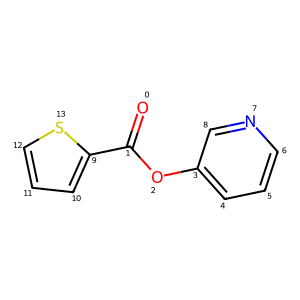

In [81]:
def get_classical_md(m):
    canon_smiles = AllChem.MolToSmiles(m, canonical=True)
    # number of H-bond acceptors for a molecule
    hba = rdMolDescriptors.CalcNumHBA(m)

    # number of H-bond donors for a molecule
    hbd = rdMolDescriptors.CalcNumHBD(m)

    # number of rings for a molecule
    nrings = rdMolDescriptors.CalcNumRings(m)

    # number of rotatable bonds for a molecule
    rtb = rdMolDescriptors.CalcNumRotatableBonds(m)

    #  topological polar surface area (TPSA) of a molecule (used medicinal chemistry metric for the optimization of a drug's ability to permeate cells.)
    psa = rdMolDescriptors.CalcTPSA(m)

    # logP and mr from https://pubs.acs.org/doi/10.1021/ci990307l:
    # logP ->  water partition coefficient as measure of lipophilicity
    # MR -> molar refractivity
    logp, mr = rdMolDescriptors.CalcCrippenDescriptors(m)

    # molecular weight
    mw = rdMolDescriptors._CalcMolWt(m)

    # Csp3: fraction of sp3 carbons
    csp3 = rdMolDescriptors.CalcFractionCSP3(m)

    # fraction of atoms belonging to Murcko framework
    # number of heavy atoms for a molecule
    fmf = GetScaffoldForMol(m).GetNumHeavyAtoms() / m.GetNumHeavyAtoms()
    hac = m.GetNumHeavyAtoms()

    # max_ring_size: maximum ring size in a molecule
    max_ring_size = len(max(m.GetRingInfo().AtomRings(), key=len, default=()))

    # QED: quantitative estimate of drug-likeness (https://www.rdkit.org/docs/source/rdkit.Chem.QED.html)
    qed = QED.qed(m)

    # ChiralCenters: number of chiral centers (assigned and unassigned)
    n_chiral_centers = len(
        Chem.FindMolChiralCenters(m, includeUnassigned=True))

    # plane of best fit (PBF), to quantify and characterize the 3D character of molecules (https://pubs.acs.org/doi/pdf/10.1021/ci300293f)
#     pbf =

    r = {'Canonical SMILE': canon_smiles,
         'HBA': hba,
         'HBD': hbd,
         'NumRings': nrings,
         'RTB': rtb,
         'lopP': logp,
         'MR': mr,
         'MW': mw,
         'Csp3': csp3,
         'fmf': fmf,
         'QED': qed,
         'HAC': hac,
         'ChiralCenters': n_chiral_centers,
         'MaxRingSize': max_ring_size,
         }
    return r


m = "O=C(Oc1cccnc1)c1cccs1"
# m = 'OCCC'
mol = AllChem.MolFromSmiles(m)
mol_descriptors = get_classical_md(mol)
for i,k in enumerate(mol_descriptors):
    print(k, mol_descriptors[k])
mol

In [82]:
import pandas as pd

# https://github.com/sp8rks/MaterialsInformatics
url = 'https://raw.github.com/sp8rks/MaterialsInformatics/master/worked_examples/RDKit_tutorial/full_dataset_dd.csv'

data = pd.read_csv(url, index_col=0)

smiles_all = data['SMILES_STD']
print('Total number of molecules: ', len(smiles_all))


D = {}
for i, smi in enumerate(smiles_all):
    m = AllChem.MolFromSmiles(smi)
    r = get_classical_md(m)
    D.update({i: r})
print(D)
data = pd.DataFrame.from_dict(D, orient='index')
data.head()

Total number of molecules:  663
{0: {'Canonical SMILE': 'Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21', 'HBA': 5, 'HBD': 0, 'NumRings': 3, 'RTB': 2, 'lopP': 1.89262, 'MR': 72.65450000000003, 'MW': 281.271, 'Csp3': 0.2, 'fmf': 0.8095238095238095, 'QED': 0.7843287546239021, 'HAC': 21, 'ChiralCenters': 0, 'MaxRingSize': 6}, 1: {'Canonical SMILE': 'O=C1C(=O)N(Cc2ccc(C(=O)N3CCCCC3)s2)c2ccc(I)cc21', 'HBA': 4, 'HBD': 0, 'NumRings': 4, 'RTB': 3, 'lopP': 3.708300000000003, 'MR': 108.75300000000003, 'MW': 480.327, 'Csp3': 0.3157894736842105, 'fmf': 0.9615384615384616, 'QED': 0.4975247606096907, 'HAC': 26, 'ChiralCenters': 0, 'MaxRingSize': 6}, 2: {'Canonical SMILE': 'CC(C)c1cc2c(cc1O)[C@@]1(C)CCCC(C)(C)[C@@H]1CC2', 'HBA': 1, 'HBD': 1, 'NumRings': 3, 'RTB': 1, 'lopP': 5.545800000000005, 'MR': 88.99080000000005, 'MW': 286.459, 'Csp3': 0.7, 'fmf': 0.6666666666666666, 'QED': 0.7177106819779207, 'HAC': 21, 'ChiralCenters': 2, 'MaxRingSize': 6}, 3: {'Canonical SMILE': 'COc1ccc(-c2cc(=O)c3c(O)cc(O)c(-c4cc(-c

,Canonical SMILE,HBA,HBD,NumRings,RTB,lopP,MR,MW,Csp3,fmf,QED,HAC,ChiralCenters,MaxRingSize
0,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,5,0,3,2,1.89262,72.6545,281.271,0.200000,0.809524,0.784329,21,0,6
1,O=C1C(=O)N(Cc2ccc(C(=O)N3CCCCC3)s2)c2ccc(I)cc21,4,0,4,3,3.70830,108.7530,480.327,0.315789,0.961538,0.497525,26,0,6
2,CC(C)c1cc2c(cc1O)[C@@]1(C)CCCC(C)(C)[C@@H]1CC2,1,1,3,1,5.54580,88.9908,286.459,0.700000,0.666667,0.717711,21,2,6
3,COc1ccc(-c2cc(=O)c3c(O)cc(O)c(-c4cc(-c5cc(=O)c...,10,3,6,6,6.04300,159.4844,580.545,0.090909,0.790698,0.212744,43,0,6
4,COc1ccc(-c2cc(=O)c3c(O)cc(O)cc3o2)cc1-c1c(O)cc...,10,5,6,4,5.43700,149.7100,552.491,0.032258,0.829268,0.189724,41,0,6


14 Index(['Canonical SMILE', 'HBA', 'HBD', 'NumRings', 'RTB', 'lopP', 'MR', 'MW',
       'Csp3', 'fmf', 'QED', 'HAC', 'ChiralCenters', 'MaxRingSize'],
      dtype='object')


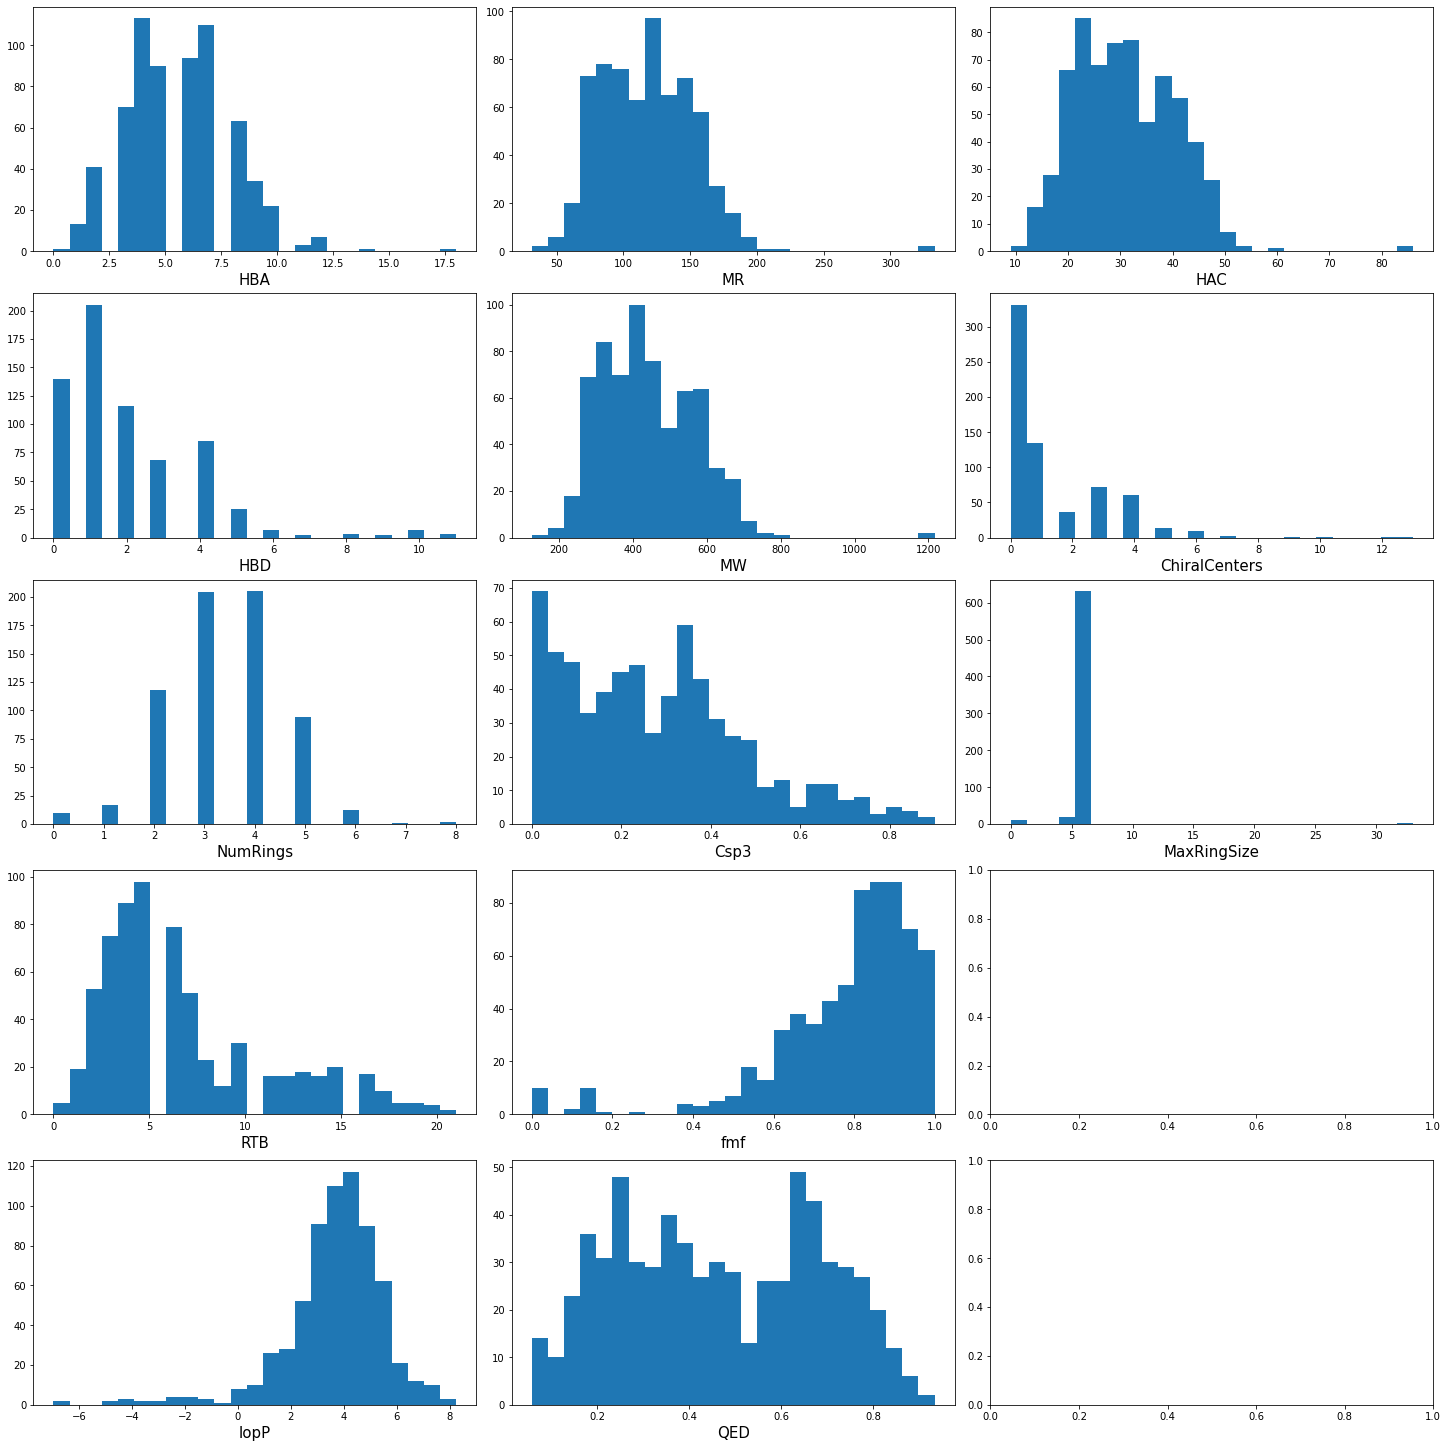

In [83]:
cols = data.columns
ncols = len(cols)
print(ncols, cols)

fig = plt.figure(layout="constrained", figsize=(20, 20))
axs = fig.subplots(nrows=5, ncols=3, squeeze=False)
ni_, nj_ = np.meshgrid(np.arange(0, 5, dtype=np.int32),
                       np.arange(0, 3, dtype=np.int32))
nij = np.column_stack((ni_.flatten(), nj_.flatten()))

for i, (ij, ci) in enumerate(zip(nij, cols[1:])):
    r = data[ci].to_numpy()
    axs[ij[0], ij[1]].hist(r, bins=25)
    axs[ij[0], ij[1]].set_xlabel(cols[i+1], fontsize=15)
plt.show()

# 1D and 2D molecular finger prints

1. **1-Dimensional**:\
   molecules are perceived as a set of substructures, such as functional groups or atom-centered fragments.
2. **2-Dimensional**:\
   molecule is represented as a graph, whose vertexes are the atoms and edges are the bonds, and specific chemical properties of atoms are considered.

 
### Molecular/Circular Fingerprints aka Morgan Fingerprints ([paper](https://pubs.acs.org/doi/10.1021/ci100050t))



* topological fingerprints for molecular characterization.
* capture molecular features relevant to molecular activity.
* used in drug activity.
* Given a *radius*, we characterize what atom is connected/surrounded to a set of "candidates".

**Problems**\
They are non-reversible, meaning given some fingerprints we can't infer the original molecule.\
People have attempted to use deep-learning for this problem.

**Papers**:
1. [Molecular/Circular Fingerprints aka Morgan Fingerprints](https://pubs.acs.org/doi/10.1021/ci100050t)
2. [data-driven molecular descriptors](https://pubs.rsc.org/en/content/articlelanding/2019/sc/c8sc04175j)
3. [Neuraldecipher](https://pubs.rsc.org/en/content/articlelanding/2020/sc/d0sc03115a)


Code below is based on [link](https://rdkit.blogspot.com/2018/10/using-new-fingerprint-bit-rendering-code.html)

<!---
https://github.com/sp8rks/MaterialsInformatics/blob/main/worked_examples/RDKit_tutorial/CircularEnumeration.png
--->

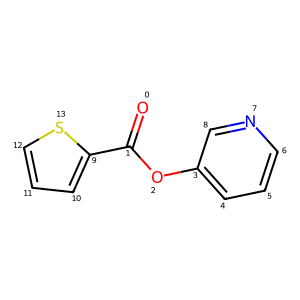

In [88]:
m = "O=C(Oc1cccnc1)c1cccs1"
# m = 'OCCC'
mol = AllChem.MolFromSmiles(m)
mol

{14: ((12, 1),), 79: ((3, 2), (13, 2)), 89: ((9, 3),), 145: ((1, 1),), 171: ((12, 3),), 228: ((5, 3),), 232: ((2, 3),), 241: ((11, 2),), 295: ((9, 2),), 322: ((3, 1),), 378: ((7, 0),), 383: ((12, 2),), 419: ((9, 1),), 437: ((6, 2),), 441: ((1, 3),), 444: ((3, 3),), 562: ((4, 2),), 597: ((1, 2),), 618: ((10, 3),), 650: ((0, 0),), 675: ((13, 0),), 695: ((2, 0),), 807: ((1, 0),), 866: ((2, 2),), 915: ((10, 2),), 959: ((4, 3),), 1010: ((6, 3),), 1043: ((5, 2),), 1088: ((5, 1), (11, 1)), 1197: ((8, 2),), 1380: ((3, 0), (9, 0)), 1535: ((8, 1),), 1567: ((13, 1),), 1586: ((7, 2),), 1603: ((7, 1),), 1729: ((2, 1),), 1750: ((4, 1), (10, 1)), 1866: ((6, 1),), 1873: ((4, 0), (5, 0), (6, 0), (8, 0), (10, 0), (11, 0), (12, 0)), 1917: ((0, 1),)}


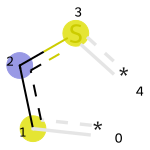

In [89]:
# fp = AllChem.GetMorganFingerprintAsBitVect(mol,3, nBits=2048)
bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(
    mol, radius=3, bitInfo=bi)
print(bi)
fp_indx = np.nonzero(np.array(fp))[0]

Draw.DrawMorganBit(mol, fp_indx[0], bi)

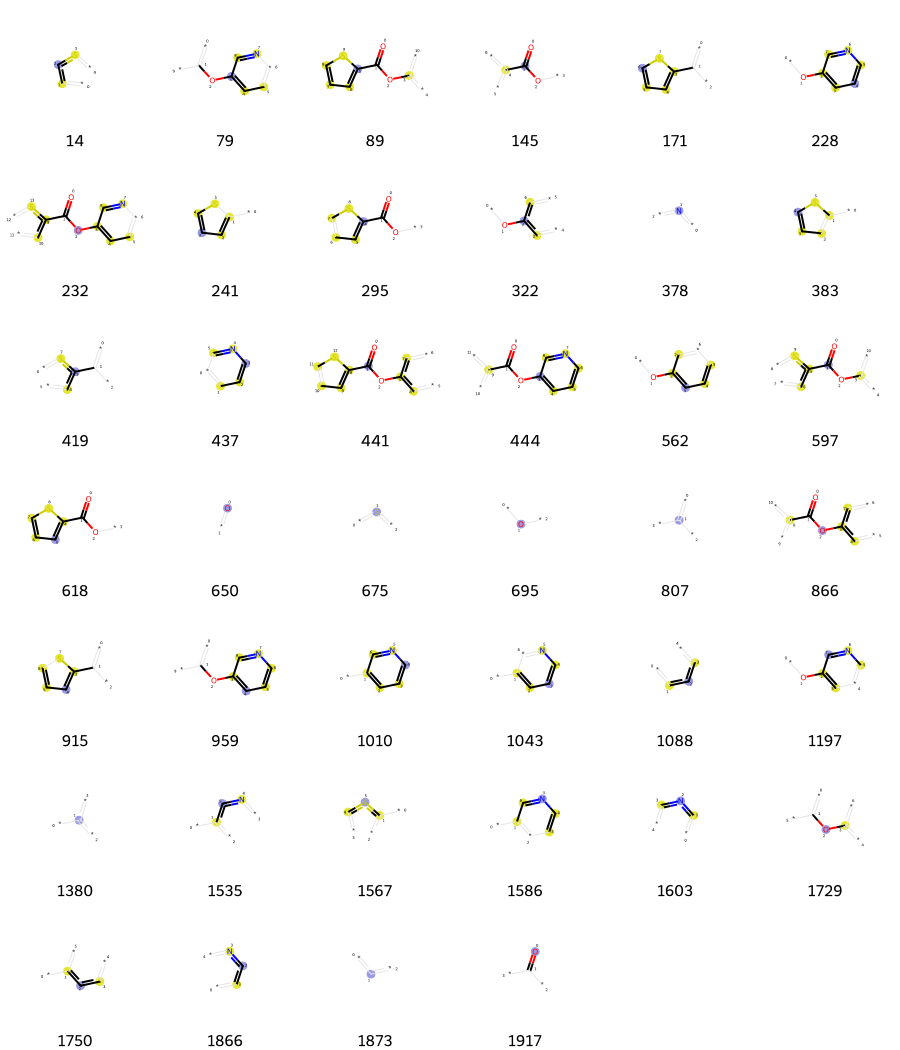

In [91]:
prints = [(mol, x, bi)for x in fp.GetOnBits()]
Draw.DrawMorganBits(prints, molsPerRow=6, legends=[
                    str(x) for x in fp.GetOnBits()])

In [93]:
def get_fingerprints(m_smiles, radius=2, nbits=2048):
  m = Chem.MolFromSmiles(m_smiles)
  m = Chem.AddHs(m)
  m_fingerprints = AllChem.GetMorganFingerprintAsBitVect(
      m, radius=radius, nBits=nbits)
  return np.asarray(m_fingerprints)

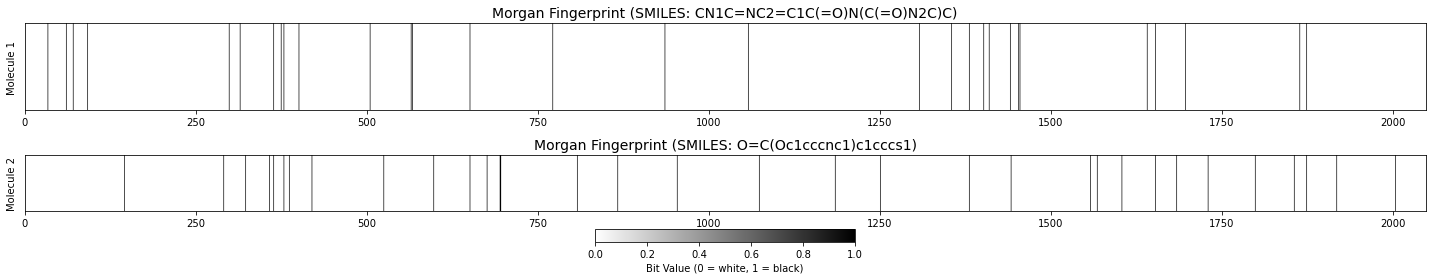

In [111]:
smiles1 = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
m1 = AllChem.MolFromSmiles(smiles1)
fp1 = get_fingerprints(smiles1)
fp1_array = np.array(fp1, dtype=np.uint8)
fp1_matrix = fp1_array.reshape(1, -1)  # 1 row, n_bits columns

smiles2 = "O=C(Oc1cccnc1)c1cccs1"
m2 = AllChem.MolFromSmiles(smiles2)
fp2 = get_fingerprints(smiles2)
fp2_array = np.array(fp2, dtype=np.uint8)
fp2_matrix = fp2_array.reshape(1, -1)  # 1 row, n_bits columns

plt.figure(figsize=(20, 4))  # Taller figure for vertical display
plt.subplot(2, 1, 1)  # First subplot (top)
plt.imshow(fp1_matrix, cmap='binary', aspect='auto')
plt.title(f"Morgan Fingerprint (SMILES: {smiles1})", fontsize=14)
plt.ylabel("Molecule 1")
plt.yticks([])  # No y-axis labels for cleaner display

plt.subplot(2, 1, 2)  # Second subplot (bottom)
plt.imshow(fp2_matrix, cmap='binary', aspect='auto')
plt.title(f"Morgan Fingerprint (SMILES: {smiles2})", fontsize=14)
plt.ylabel("Molecule 2")
plt.yticks([])  # No y-axis labels for cleaner display
plt.colorbar(label="Bit Value (0 = white, 1 = black)", orientation='horizontal', pad=0.2)
plt.tight_layout()  # Ensure no overlap
plt.show()

# Molecular graphs

Molecules can be represented as *Graphs* where,
> **nodes** contains the information of the atoms -> atomic number of atom type \
> **edges** represents the connectivity -> bond order or type

**A graph represents the topology of our molecule!**
> (topology -> connectivity)

## SMILES
The **simplified molecular-input line-entry system** (SMILES) is a specification in the form of a line notation for describing the structure of chemical species using short ASCII strings. 

The SMILES description is based on,
1. Atoms ```[Co+3]```
2. Bonds ```. - = # $ : / \``` 
   1. ```.``` no bonds ```[Na+].[Cl-]```
   2. ```- = # $``` are single, double, triple, quadruple
   3. ```:``` "one and a half" bond
   4.  ```/``` or ```\``` to indicate stereochemical configuration
3. Rings
   * cyclopropene is usually written ```C1=CC1```
4. Branching
   * It uses ```()``` 

from [Wikipedia](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)

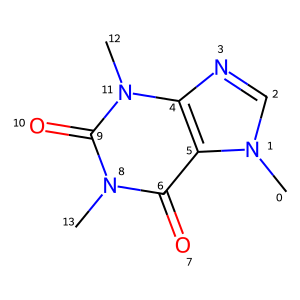

In [59]:
caff_sm = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
m = AllChem.MolFromSmiles(caff_sm)
m

SMILES usually avoid the notation with ```H``` to reduce the string length.
However, one could add them in RDKiT.

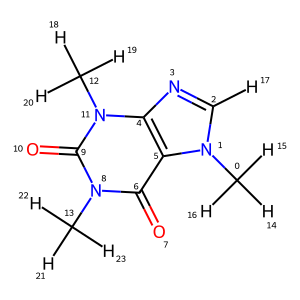

In [60]:
m_wH = Chem.rdmolops.AddHs(m)
m_wH

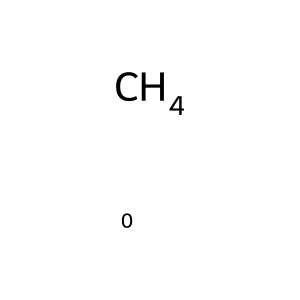

In [61]:
ch4_sm = 'C'
m_ch4 = AllChem.MolFromSmiles(ch4_sm)
m_ch4

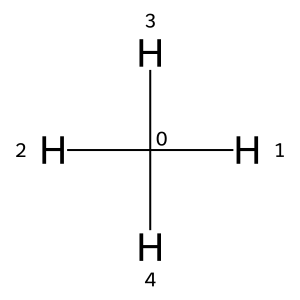

In [62]:
m_ch4_wH = Chem.rdmolops.AddHs(m_ch4)
m_ch4_wH

## canonical SMILES
RDKit a canonicalization algorithm uses rules to produce a unique ordering for the atoms

**Aspirin**: O=C(C)Oc1ccccc1C(=O)O \
(from [Wikipedia](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwitk7DA5839AhXYkIkEHa0dDrgQFnoECA8QAQ&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FAspirin&usg=AOvVaw02IeN5OW-BJ2TIBNLoNsgI))

<img src="https://raw.github.com/RodrigoAVargasHdz/CHEM-4PB3/master/Course_Notes/Figures/Canonical-a-and-randomized-b-SMILES-representations-of-aspirin-Randomized-SMILES.png"  width="600" height="300">


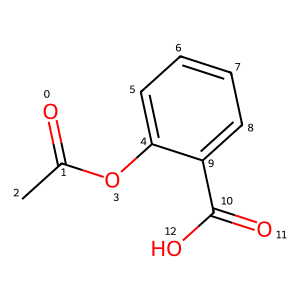

In [63]:
molec_smiles = "O=C(C)Oc1ccccc1C(=O)O" #'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'  # 'OCCC'
molecule = AllChem.MolFromSmiles(molec_smiles)
molecule

In [64]:
unique_smiles = AllChem.MolToSmiles(molecule, canonical=True)
print(molec_smiles)
print(unique_smiles)

O=C(C)Oc1ccccc1C(=O)O
CC(=O)Oc1ccccc1C(=O)O


## Introduction to SMARTS

**SMARTS** stands for **SMILES Arbitrary Target Specification**. <br>
It is an extension of the SMILES notation and is used in cheminformatics for specifying substructure patterns in molecules. <br>
SMARTS is widely used for searching molecular databases because it can represent more complex patterns and molecular structures than SMILES. <br>

**Key Features of SMARTS**
* **Versatility in Pattern Representation**: SMARTS can represent a wide range of chemical patterns, from simple atomic properties to complex molecular structures.
* **Logical Operators**: It supports logical operators (AND, OR, NOT), allowing for the construction of sophisticated query patterns.
* **Recursion**: SMARTS supports recursive SMARTS, enabling nested substructure queries.

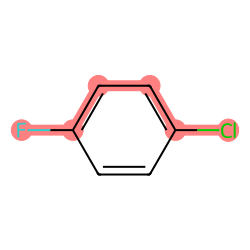

In [112]:
from IPython.display import Image
from rdkit.Chem.Draw import rdMolDraw2D

smi = 'c1cc(F)ccc1Cl'
mol = Chem.MolFromSmiles(smi)

patt = Chem.MolFromSmarts('ClccccF')
hit_ats = list(mol.GetSubstructMatch(patt))

hit_bonds = []
for bond in patt.GetBonds():
   aid1 = hit_ats[bond.GetBeginAtomIdx()]
   aid2 = hit_ats[bond.GetEndAtomIdx()]

   hit_bonds.append(mol.GetBondBetweenAtoms(aid1, aid2).GetIdx())

d = rdMolDraw2D.MolDraw2DCairo(250, 250)  # or MolDraw2DCairo to get PNGs
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=hit_ats,
                                   highlightBonds=hit_bonds)
d.FinishDrawing()  # Finish drawing

png_data = d.GetDrawingText()
Image(data=png_data)

Molecule Set for Fragment Matching


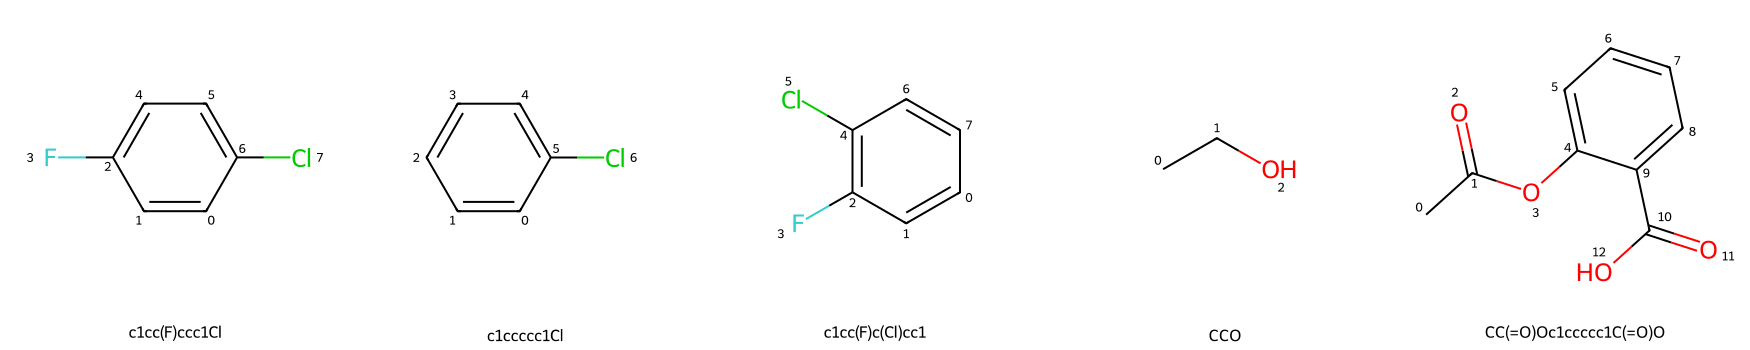


Fragment Matching Results
Fragment found in molecule: c1cc(F)ccc1Cl
Fragment NOT found in molecule: c1ccccc1Cl
Fragment NOT found in molecule: c1cc(F)c(Cl)cc1
Fragment NOT found in molecule: CCO
Fragment NOT found in molecule: CC(=O)Oc1ccccc1C(=O)O


In [127]:
# List of SMILES strings for molecules
smiles_list = ['c1cc(F)ccc1Cl', 'c1ccccc1Cl',
               'c1cc(F)c(Cl)cc1', 'CCO', 'CC(=O)Oc1ccccc1C(=O)O']

# smiles_list = smiles_all.sample(5).to_list() # 5 random molecules from the database

# Define the SMARTS pattern
fragment = Chem.MolFromSmarts('ClccccF')  # '*(F)(F)F'

# Convert SMILES to RDKit molecules
molecules = [Chem.MolFromSmiles(smi) for smi in smiles_list]

# Step 1: Display molecules in a grid
print("Molecule Set for Fragment Matching")
grid_img = Draw.MolsToGridImage(molecules, legends=smiles_list, molsPerRow=len(smiles_list), subImgSize=(350, 350))
display(grid_img)

# Step 2: Check for fragment matches and print results
print("\nFragment Matching Results")
for smi, mol in zip(smiles_list, molecules):
    if mol is None:
        print(f"Invalid SMILES: {smi}")
        continue
    
    match = mol.HasSubstructMatch(fragment)  # Check if the fragment exists
    if match:
        print(f"Fragment found in molecule: {smi}")
    else:
        print(f"Fragment NOT found in molecule: {smi}")

[#6]1:[#7]:[#6]:[#6](-[#8]-[#0]):[#6]:[#6]:1


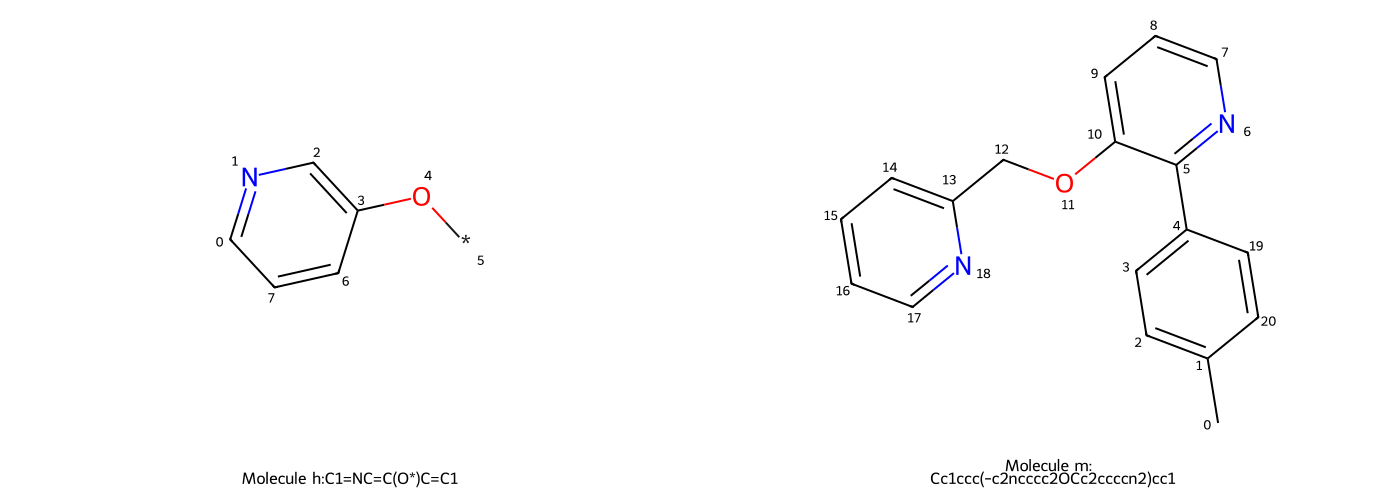

In [128]:
# Molecules from SMILES
h_smiles = "C1=NC=C(O*)C=C1"  # Molecule with dummy atom
m_smiles = "Cc1ccc(-c2ncccc2OCc2ccccn2)cc1"  # Second molecule

h = Chem.MolFromSmiles(h_smiles)
print(Chem.MolToSmarts(h))
m = Chem.MolFromSmiles(m_smiles)


image_size = (700, 500)  # Adjust as needed

# Create a single image with both molecules
img = Draw.MolsToGridImage([h, m], legends=[
                           f"Molecule h:{h_smiles}", f"Molecule m: \n {m_smiles}"],  molsPerRow=2, subImgSize=image_size)

# Display the combined image
display(img)

((7, 6, 5, 10, 11, 12, 9, 8),)


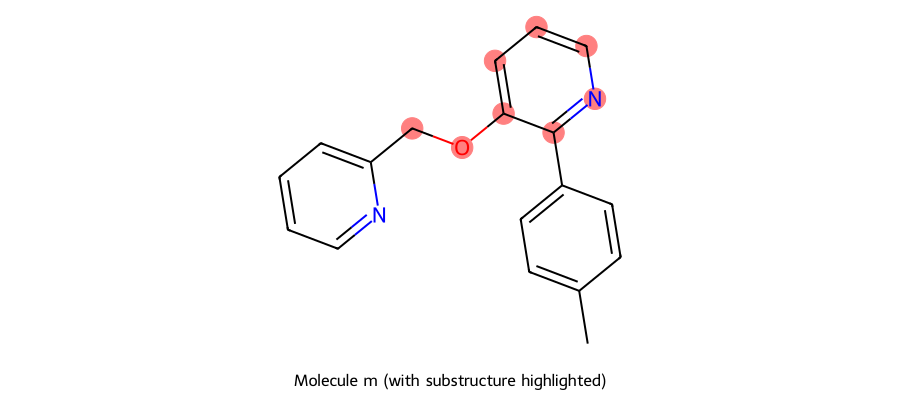

Does 'm' have a substructure match of 'h'?:  (7, 6, 5, 10, 11, 12, 9, 8)


In [129]:
# Generate 2D coordinates for both molecules
rdDepictor.Compute2DCoords(h)
rdDepictor.Compute2DCoords(m)

# Convert dummies into queries for substructure matching
p = Chem.AdjustQueryParameters.NoAdjustments()
p.makeDummiesQueries = True
hq = Chem.AdjustQueryProperties(h, p)
matches = m.GetSubstructMatches(hq) 
print(matches) # atoms in the graph

for match in matches:
    # Specify the size of the image (width, height) in pixels
    img_size = (900, 400)  # Example size, you can adjust as needed
    img2_highlighted = Draw.MolToImage(m, size=img_size, highlightAtoms=match,
                                    legend="Molecule m (with substructure highlighted)")
    display(img2_highlighted)

# Print whether 'm' has a substructure match of 'h'
print("Does 'm' have a substructure match of 'h'?: ", match)

## Molecules are Graphs

Molecules can be considered as graphs where,
* atoms are the **nodes**
* bonds are the **edges**

Depending on the type of atom and bond, is the information that we will use to represent the graph. 


Today's tutorial is based on the following online tutorial,<br>
[How to turn a SMILES string into a molecular graph for Pytorch Geometric](https://www.blopig.com/blog/2022/02/how-to-turn-a-smiles-string-into-a-molecular-graph-for-pytorch-geometric/)

### Atoms (Nodes)
We can try to describe each atom in the molecule, meaning each node in the graph, using some individual properties.

The ```atom``` class in ```RDKit``` contains all the necessary information of each atom that conforms a molecule, [link](https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.Atom). <br>
1. ```Atom.GetAtomicNum()```
2. ```Atom.GetSymbol()```
3. ```Atom.GetHybridization()```
4. ```Atom.GetIsAromatic()```
5. ```Atom.GetIsotope()```
6. ```Atom.GetNeighbors()```
7. ```Atom.IsInRing()```
8. ```Atom.GetChiralTag()```

All these additional information can be used in the feature representation of each node. 

It worth mentioning that, the hand crafting of the feature representation is "case-specific".

0 C 6 False SP3 False
1 N 7 True SP2 True
2 C 6 True SP2 True
3 N 7 True SP2 True
4 C 6 True SP2 True
5 C 6 True SP2 True
6 C 6 True SP2 True
7 O 8 False SP2 False
8 N 7 True SP2 True
9 C 6 True SP2 True
10 O 8 False SP2 False
11 N 7 True SP2 True
12 C 6 False SP3 False
13 C 6 False SP3 False


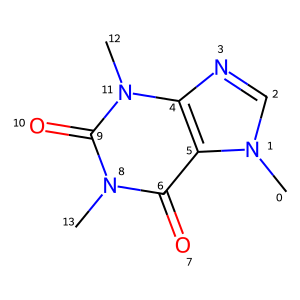

In [69]:
def get_nodes_features(mol):
    dictionary_atoms = ['C', 'O', 'N', 'H', 'F']
    for i,a in enumerate(mol.GetAtoms()):
        print(i, a.GetSymbol(), a.GetAtomicNum(),a.GetIsAromatic(), a.GetHybridization(), a.IsInRing())

molec_smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
mol = AllChem.MolFromSmiles(molec_smiles)
get_nodes_features(mol)
mol

## Bonds (Edges)
The connectivity of the molecular graph tells us which atom interact with the other atoms. <br>
This connectivity matrix is known as the **adjacency matrix**.

In [70]:
atoms = mol.GetAtoms()
n_atoms = mol.GetNumAtoms()
atoms_list = [a.GetSymbol() for a in atoms]
A = GetAdjacencyMatrix(mol)

print(n_atoms)
print(atoms_list)
# print(A)

# assert 0
(rows, cols) = np.nonzero(A)
for (k, (i, j)) in enumerate(zip(rows, cols)):
  bond = mol.GetBondBetweenAtoms(int(i), int(j))
  print(i, j, atoms_list[int(i)], atoms_list[int(j)], bond.GetBondType())
  # permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]
  # bond_type_enc = np.one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)

14
['C', 'N', 'C', 'N', 'C', 'C', 'C', 'O', 'N', 'C', 'O', 'N', 'C', 'C']
0 1 C N SINGLE
1 0 N C SINGLE
1 2 N C AROMATIC
1 5 N C AROMATIC
2 1 C N AROMATIC
2 3 C N AROMATIC
3 2 N C AROMATIC
3 4 N C AROMATIC
4 3 C N AROMATIC
4 5 C C AROMATIC
4 11 C N AROMATIC
5 1 C N AROMATIC
5 4 C C AROMATIC
5 6 C C AROMATIC
6 5 C C AROMATIC
6 7 C O DOUBLE
6 8 C N AROMATIC
7 6 O C DOUBLE
8 6 N C AROMATIC
8 9 N C AROMATIC
8 13 N C SINGLE
9 8 C N AROMATIC
9 10 C O DOUBLE
9 11 C N AROMATIC
10 9 O C DOUBLE
11 4 N C AROMATIC
11 9 N C AROMATIC
11 12 N C SINGLE
12 11 C N SINGLE
13 8 C N SINGLE


In [71]:
for i in range(len(atoms_list)+1):
  if i == 0:
    print('   ', end=' ')
    for j, ai in enumerate(atoms_list):
      print('%s:%s' % (ai, j), end=' ')
  else:
    j = i-1
    print('%s:%s ' % (atoms_list[j], j), end=' ')
    for jj, ami in enumerate(A[j]):
      if jj < 11:
        print(' %s ' % (ami), end=' ')
      else:
        print(' %s  ' % (ami), end=' ')
  print('\n')

    C:0 N:1 C:2 N:3 C:4 C:5 C:6 O:7 N:8 C:9 O:10 N:11 C:12 C:13 

C:0   0   1   0   0   0   0   0   0   0   0   0   0    0    0   

N:1   1   0   1   0   0   1   0   0   0   0   0   0    0    0   

C:2   0   1   0   1   0   0   0   0   0   0   0   0    0    0   

N:3   0   0   1   0   1   0   0   0   0   0   0   0    0    0   

C:4   0   0   0   1   0   1   0   0   0   0   0   1    0    0   

C:5   0   1   0   0   1   0   1   0   0   0   0   0    0    0   

C:6   0   0   0   0   0   1   0   1   1   0   0   0    0    0   

O:7   0   0   0   0   0   0   1   0   0   0   0   0    0    0   

N:8   0   0   0   0   0   0   1   0   0   1   0   0    0    1   

C:9   0   0   0   0   0   0   0   0   1   0   1   1    0    0   

O:10   0   0   0   0   0   0   0   0   0   1   0   0    0    0   

N:11   0   0   0   0   1   0   0   0   0   1   0   0    1    0   

C:12   0   0   0   0   0   0   0   0   0   0   0   1    0    0   

C:13   0   0   0   0   0   0   0   0   1   0   0   0    0    0   



RDKit also allows you to get the specific information between each bond of the molecule. 
1. bond type: ```bond.GetBondType()```
2. conjugate bonds: ```bond.GetIsConjugate()```
3. aromatic bond in ring: ```bond.IsInRing()```

In [72]:
def get_edges_features(mol):
    for bond in mol.GetBonds():
        begin_idx = bond.GetBeginAtomIdx()  # Index of the first atom in the bond
        end_idx = bond.GetEndAtomIdx()      # Index of the second atom in the bond

        # Get the corresponding atom objects
        begin_atom = mol.GetAtomWithIdx(begin_idx)
        end_atom = mol.GetAtomWithIdx(end_idx)
        print(f"{begin_atom.GetSymbol()}:{begin_idx}",
              f"{end_atom.GetSymbol()}:{end_idx}", bond.GetBondType(), bond.GetIsConjugated(), bond.IsInRing())

print(get_edges_features(mol))

C:0 N:1 SINGLE False False
N:1 C:2 AROMATIC True True
C:2 N:3 AROMATIC True True
N:3 C:4 AROMATIC True True
C:4 C:5 AROMATIC True True
C:5 C:6 AROMATIC True True
C:6 O:7 DOUBLE True False
C:6 N:8 AROMATIC True True
N:8 C:9 AROMATIC True True
C:9 O:10 DOUBLE True False
C:9 N:11 AROMATIC True True
N:11 C:12 SINGLE False False
N:8 C:13 SINGLE False False
C:5 N:1 AROMATIC True True
N:11 C:4 AROMATIC True True
None


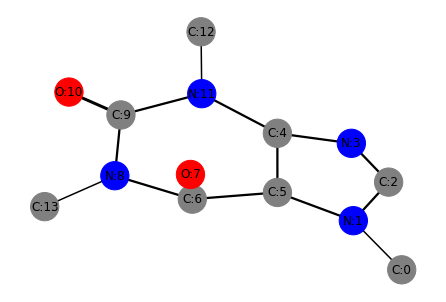

In [73]:
# define the function for converting rdkit object to networkx object 
def molecular_graph(mol):
    
    # core function to construct a molecular graph
    def mol_to_nx(mol):
        G = nx.Graph()

        for atom in mol.GetAtoms():
            
            G.add_node(atom.GetIdx(),
                    atomic_num=atom.GetAtomicNum(),
                    is_aromatic=atom.GetIsAromatic(),
                    atom_symbol=atom.GetSymbol())

        for bond in mol.GetBonds():
            # bt = bond.GetBondType()
            bt = bond.GetBondTypeAsDouble()
            # bt = bt['bond_type']
            G.add_edge(bond.GetBeginAtomIdx(),
                    bond.GetEndAtomIdx(),
                    bond_type=bt,
                    weight=1.5*bt)

        return G

    # conver rdkit object to networkx object 
    mol_nx = mol_to_nx(mol)

    mol_atom = nx.get_node_attributes(mol_nx, 'atom_symbol')
    mol_atom_w_indx = mol_atom.copy()
    for i,k in enumerate(mol_atom_w_indx):
        mol_atom_w_indx[k] = '%s:%s'%(mol_atom[i],i)

    color_map = {'C': 'grey',
                'O': 'red',
                'N': 'blue',
                'H': 'white',
                }

    mol_colors = []
    for idx in mol_nx.nodes():
        if (mol_nx.nodes[idx]['atom_symbol'] in color_map):
            mol_colors.append(
                color_map[mol_nx.nodes[idx]['atom_symbol']])
        else:
            mol_colors.append('gray')
    
    edge_weight = []
    bond_types_str = ['SINGLE', 'DOUBLE','TRIPLE', 'AROMATIC']

    edges = mol_nx.edges()
    weights = [mol_nx[u][v]['weight'] for u, v in edges]
    nx.draw(mol_nx,
            labels=mol_atom_w_indx,
            with_labels=True,
            node_color=mol_colors,
            width=weights,
            node_size=800)

    plt.show()

caff_sm = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
mol = AllChem.MolFromSmiles(caff_sm)
# mol_wH = Chem.rdmolops.AddHs(mol)
molecular_graph(mol)



# XYZ coordinates and 3D plot

In [74]:
def get_xyz_coordinates(m_rdkit):
    xyz = Chem.MolToMolBlock(m_rdkit) # Generates a 3D conformer
    n_atoms = m_rdkit.GetNumAtoms() # total numbers of atoms

    xyz_ = []
    for l in xyz.splitlines()[4:4+m_rdkit.GetNumAtoms()]:
        l = l.split()
        xyz_.append(l[:4])

    xyz_str = '%s\n * (null), Energy   -1000.0000000\n' % (n_atoms)
    for xyzi in xyz_:
        xyzi_str = '%s     %.4f     %.4f     %.4f\n' % (
            xyzi[3], float(xyzi[0]), float(xyzi[1]), float(xyzi[2]))
        xyz_str += xyzi_str
    return xyz_str

def draw_3d(smiles,bool_add_H=True):

    m3 = AllChem.MolFromSmiles(smiles)
    if bool_add_H:
        m3 = Chem.AddHs(m3)
    AllChem.EmbedMolecule(m3,randomSeed=0xf00d)
    
    n_atoms = m3.GetNumAtoms()

    xyz_str = get_xyz_coordinates(m3)
    xyzview = py3Dmol.view(width=400, height=400)
    xyzview.addModel(xyz_str, 'xyz')
    xyzview.setStyle({'sphere': {'radius': 0.35}, 'stick': {'radius': 0.1}})
    xyzview.setBackgroundColor('0xeeeeee')
    xyzview.zoomTo()
    xyzview.show()


In [75]:
caff_sm = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
# caff_sm = 'C=C'
draw_3d(caff_sm)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol